In [107]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datetime
from graphviz import Digraph
import time
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

In [230]:
sns.set(rc={'figure.figsize':(12.7,10.27)})

In [136]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
df = pd.read_csv('/Users/kost/Desktop/решено/data/statistics-07-20.csv',sep=';',parse_dates=['operation_date'])
train_ops = pd.read_csv('/Users/kost/Desktop/решено/data/poezd.csv', sep=';', encoding='utf-8')
car_ops = pd.read_csv('/Users/kost/Desktop/решено/data/codes.csv',sep=';', encoding='utf-8')

In [4]:
ndf = df.sort_values(by=['operation_st_id','car_number','operation_date']).drop_duplicates().reset_index(drop=True)

### Первичный анализ датасета

In [223]:
# по номеру операции вывести описание из справочников по вагонами и поездам
def get_op_info(cop):
    print(f'Операция с вагоном: {car_ops[car_ops.index_code == operation_code].values[0]}')
    print(f'Операция с поездом: {train_ops[train_ops.index_code == operation_code].values[0]}')
    
get_op_info(3)

Операция с вагоном: [3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
Операция с поездом: [3 'Пс' 'Просл. поездом станции без остановки (без приема/сдачи)']


In [263]:
# уникальные станции по операциям
df.operation_st_id.value_counts()[df.operation_st_id.value_counts() == 50]

2,000,037,832.00    50
2,000,038,836.00    50
Name: operation_st_id, dtype: int64

In [131]:
# уникальные вагоны по операциям
df.car_number.value_counts()

55864821    310
55822928    290
55927537    287
55626428    273
55701130    272
           ... 
60175320      1
95378899      1
29064912      1
57448243      1
60025954      1
Name: car_number, Length: 441248, dtype: int64

In [197]:
print(f'Временной диапазон датафрейма:\nmin: {ndf.operation_date.min()}\nmax: {ndf.operation_date.max()}')

Временной диапазон датафрейма:
min: 2020-07-01 00:00:00
max: 2020-07-31 23:59:00


In [205]:
ndf.operation_car[ndf.operation_st_id.isna()].value_counts()

3.00     123
78.00     61
19.00     58
4.00      55
80.00     52
2.00      49
13.00     43
18.00     37
20.00     36
79.00     35
21.00     25
81.00     14
11.00     10
Name: operation_car, dtype: int64

### Избавляемся от пропусков в operation_car

#### Всего операций с поездами в датасете

In [139]:
ndf.operation_car.unique()

array([ 3., 18.,  4.,  2., 78., 20., 21., 80., 11., 81., 10., 28., 19.,
       79., 14., 29., 23., 26., 16., 27., 13.])

In [140]:
for i in ndf.operation_train[ndf.operation_train.notnull()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

5.0 ['Окончание формирования поезда']
4.0 ['Расформирование поезда']
2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
72.0 ['Отцепка вагонов']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
71.0 ['Прицепка вагонов']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
44.0 ['Подача маршрута под грузовые операции']
42.0 ['Отпр. поезда со станции со сдачей на соседнее отделение']
30.0 ['Отпр. (просл.) поезда со станции "чужой" дороги в направл. "нашей" дороги']
64.0 ['Приб. пассажирского поезда на станцию назначения']
54.0 ['Прекращение "жизни" поезда 3-й категории']
35.0 ['Образование соединенного поезда']


#### Операции с поездом когда нет данных по операции с вагоном:

In [141]:
for i in ndf.operation_train[ndf.operation_car.isna()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

In [142]:
# все пропуски можно заменить операцией отправления
ndf.operation_car = ndf.operation_car.fillna(2)

In [143]:
print(f'{ndf.car_number.nunique() - ndf.car_number[ndf.operation_car == 2].nunique()} вагонов из датасета было не отправлено за рассматриваемый период')

128413 вагонов из датасета было не отправлено за рассматриваемый период


In [144]:
ndf.car_number[ndf.operation_car == 2].unique().shape

(312835,)

### Избавляемся от пропусков в danger

In [ ]:
ndf.danger = ndf.danger.fillna(0)

### Отрисовка графов последовательностей операций

In [6]:
def ops_tr_for_set_of_carts(cartsSet: set) -> pd.DataFrame:
    """
    Builds DF with historical data of changes in states from one operation to another for a set of carts IDs.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dataframe with following format (note that state changes are not unique)
        from 	to
    0 	3 	    4
    1 	4 	    3
    2 	3 	    4
    3 	4 	    3
    ...
    """
    stateChangeDF = pd.DataFrame(columns=['from', 'to'])
    iter = 0
    for cartID in tqdm(cartsSet):
        iter += 1
        opsListCart = list(ndf.operation_car[ndf.car_number == cartID])
        state_change = pd.DataFrame({'from': opsListCart[:-1], 'to': opsListCart[1:]})
        stateChangeDF = pd.concat(
            [stateChangeDF, state_change],
            axis=0,
            join="outer",
            ignore_index=True,
            keys=None,
            levels=None,
            names=None,
            verify_integrity=False,
            copy=True,
        )
    return stateChangeDF


def count_ops_transitions(cartsSet: set) -> dict:
    """
    Builds a dict with unique operation changes and state change frequency.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dict with unique operations and their quantity. See example below:
    {'3->4': 2, '4->3': 2, '3->2': 1, '2->80': 1}
    """
    sChangeList = []
    linksDict: dict = {}
    sChangeDF = ops_tr_for_set_of_carts(cartsSet)
    for i in range(sChangeDF.shape[0]):
        src = str(list(sChangeDF.loc[i])[0])
        trg = str(list(sChangeDF.loc[i])[1])
        sChangeList.append(src + "->" + trg)
    for entry in sChangeList:
        key = str(entry)
        if key in linksDict.keys():
            linksDict[key] += 1
        else:
            linksDict[key] = 1
    return linksDict

In [ ]:
ndf.operation_st_id.value_counts()

In [365]:
# cars
carSet = {37843901}
# carSet = {94033792}
# carSet = {62324355}

# stations
# option A - 
# carSet = set(ndf.car_number[ndf.operation_st_id == 2000038976])

# option B - drop all ops chains with less then 3
# st = ndf.car_number[ndf.operation_st_id == 2001930816].value_counts()
# carSet = set(st[st > 2].index)

100%|██████████| 1/1 [00:00<00:00, 79.65it/s]


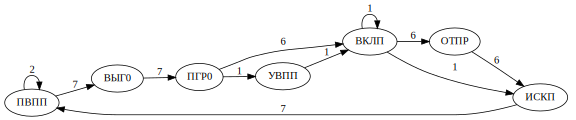

In [416]:
sdict = count_ops_transitions(carSet)

DG = Digraph('finite_state_machine', filename='ops_fsm')
DG.attr(rankdir='LR', size='8,5')

for key in sdict:
    src = car_ops[car_ops.index_code == float(key.split('->')[0])].values[0][1]
    dst = car_ops[car_ops.index_code == float(key.split('->')[1])].values[0][1]
    DG.edge(src, dst, weight=str(sdict[key]), label=str(sdict[key]))

DG

In [414]:
td = ndf.operation_date[ndf.index == cops[i]].values[0] - ndf.operation_date[ndf.index == cops[i-1]].values[0]
print(td.astype('timedelta64[m]'))

173 minutes


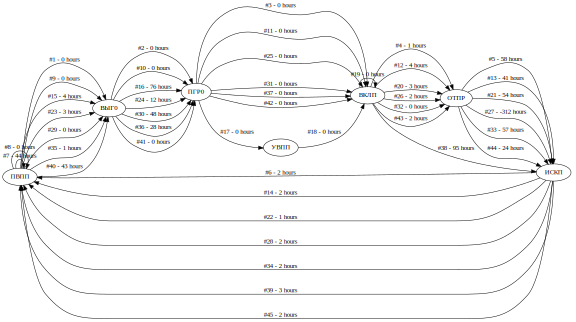

In [415]:
# построить граф переходов между операциями по вагонам
car_number = 37843901

cops = ndf.operation_car[ndf.car_number == car_number].index
del(DG)
DG = Digraph(f'FSM for car #{car_number}', filename='ops_fsm_per_car')
DG.attr(rankdir='LR', size='8,5')

for i in range(1,len(cops)):
    src = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i-1]].values[0]].values[0]
    dst = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i]].values[0]].values[0]
    td = ndf.operation_date[ndf.index == cops[i]].values[0] - ndf.operation_date[ndf.index == cops[i-1]].values[0]
    td = str(td.astype('timedelta64[h]'))
    DG.edge(src, dst, label=f'#{str(i)} - {td}')


DG

### Анализ цепочек операций

### Выборка по станции. Словарь с последовательностями операций по вагонам

In [179]:
def extract_ops_chains(st_id: int) -> dict:
    '''
    Собирает цепочки операций по вагонам для заданной станции
    '''
    cars = {}
    for i in tqdm(ndf.car_number[ndf.operation_st_id == st_id].unique()):
        cars[i] = str(ndf.operation_car[ndf.operation_st_id == st_id][ndf.car_number == i].values)
        cars[i] = cars[i][1:-1].strip().replace('\n','')
    return cars

In [180]:
cars = extract_ops_chains(2000035706)
cars

100%|██████████| 39/39 [00:00<00:00, 106.38it/s]


{37845930: '3. 80. 28. 19. 81.  4.  2.',
 37845955: '3. 80. 28. 19. 81.  4.  2.',
 42242735: '80.',
 52007580: '3.  3. 80. 28.',
 53190203: '3. 80. 21. 18.  4.  2.',
 53706008: '3. 80.',
 53807384: '3. 80. 21. 18.  4.  2.',
 55509392: '3. 80.',
 55760656: '3. 80. 21. 18.  4.  2.',
 55804397: '3. 80.',
 55808646: '3. 80.',
 55808687: '3. 80.',
 55808729: '3. 80.',
 55816227: '3. 80.',
 55833081: '3. 80.',
 55846083: '3. 80.',
 55846158: '3. 80.',
 55853279: '3. 80.',
 55853352: '3. 80.',
 55853410: '3. 80.',
 55873186: '3. 80.',
 55873459: '3. 80.',
 55892988: '3. 80.',
 55893036: '3. 80.',
 55893077: '3. 80.',
 55893119: '3. 80.',
 55893127: '3. 80.',
 55893176: '3. 80.',
 55893234: '3. 80.',
 55893259: '3. 80.',
 55893283: '3. 80.',
 55893374: '3. 80.',
 55893465: '3. 80.',
 55893531: '3. 80.',
 55893549: '3. 80.',
 55909014: '3. 80.',
 55909113: '3. 80.',
 55909188: '3. 80.',
 55909212: '3. 80.'}

In [181]:
def sort_dict(dct: dict) -> dict:
    return dict(sorted(dct.items(), key=lambda item: item[1], reverse=True))

In [182]:
sort_dict(cars)

{42242735: '80.',
 37845930: '3. 80. 28. 19. 81.  4.  2.',
 37845955: '3. 80. 28. 19. 81.  4.  2.',
 53190203: '3. 80. 21. 18.  4.  2.',
 53807384: '3. 80. 21. 18.  4.  2.',
 55760656: '3. 80. 21. 18.  4.  2.',
 53706008: '3. 80.',
 55509392: '3. 80.',
 55804397: '3. 80.',
 55808646: '3. 80.',
 55808687: '3. 80.',
 55808729: '3. 80.',
 55816227: '3. 80.',
 55833081: '3. 80.',
 55846083: '3. 80.',
 55846158: '3. 80.',
 55853279: '3. 80.',
 55853352: '3. 80.',
 55853410: '3. 80.',
 55873186: '3. 80.',
 55873459: '3. 80.',
 55892988: '3. 80.',
 55893036: '3. 80.',
 55893077: '3. 80.',
 55893119: '3. 80.',
 55893127: '3. 80.',
 55893176: '3. 80.',
 55893234: '3. 80.',
 55893259: '3. 80.',
 55893283: '3. 80.',
 55893374: '3. 80.',
 55893465: '3. 80.',
 55893531: '3. 80.',
 55893549: '3. 80.',
 55909014: '3. 80.',
 55909113: '3. 80.',
 55909188: '3. 80.',
 55909212: '3. 80.',
 52007580: '3.  3. 80. 28.'}

### Аггрегация вагонов по типовым последовательностям операций

In [183]:
def agg_by_val(dct: dict) -> dict:
    '''
    Аггрегирует номера вагонов по цепочкам операций
    '''
    res = {}
    for i, v in dct.items():
        res[v] = [i] if v not in res.keys() else res[v] + [i]
    return res

In [184]:
agg_by_val(sort_dict(cars))

{'80.': [42242735],
 '3. 80. 28. 19. 81.  4.  2.': [37845930, 37845955],
 '3. 80. 21. 18.  4.  2.': [53190203, 53807384, 55760656],
 '3. 80.': [53706008,
  55509392,
  55804397,
  55808646,
  55808687,
  55808729,
  55816227,
  55833081,
  55846083,
  55846158,
  55853279,
  55853352,
  55853410,
  55873186,
  55873459,
  55892988,
  55893036,
  55893077,
  55893119,
  55893127,
  55893176,
  55893234,
  55893259,
  55893283,
  55893374,
  55893465,
  55893531,
  55893549,
  55909014,
  55909113,
  55909188,
  55909212],
 '3.  3. 80. 28.': [52007580]}

In [185]:
# подсчет цепочек операций совпадающих по вагонам
ocl = agg_by_val(sort_dict(cars))
for key in ocl:
    ocl[key] = len(ocl[key])
sort_dict(ocl)

{'3. 80.': 32,
 '3. 80. 21. 18.  4.  2.': 3,
 '3. 80. 28. 19. 81.  4.  2.': 2,
 '80.': 1,
 '3.  3. 80. 28.': 1}

In [186]:
ops = '3. 80. 28. 19. 81.  4.  2.'
ops = list(map(float, ops.split()))
ops

[3.0, 80.0, 28.0, 19.0, 81.0, 4.0, 2.0]

In [176]:
# выбрать цепочку операций для определенного car_number
# ops = list(ndf.operation_car[ndf.car_number == 62324355].values)

In [188]:
# по списку операций ops вывести информацию по цепочке операций
for i in ops:
    print(car_ops[car_ops.index_code == i].values[0])

[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']
[28 'ВЫГ0' 'ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
[19 'ПГР9' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
[81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']


## misc

### Профайлер

In [ ]:
## profiler code
# dt = datetime.datetime.now().strftime("%m/%d/%y - %H:%M")
# profile = ProfileReport(ndf, title=dt, explorative=True)
# fname = 'pd-report.html'
# profile.to_file(output_file=fname)

### Графики

<ipython-input-108-7b71033e5deb>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xxx = ndf[ndf.operation_st_id == 2001930816][ndf.car_number == 28036507].sort_values(by='operation_date')[['operation_date','operation_car']].reset_index(drop=True)


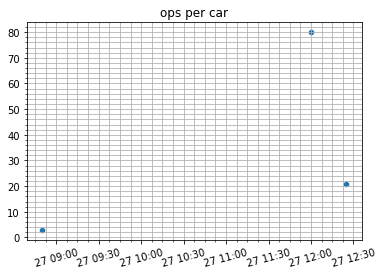

In [108]:
xxx = ndf[ndf.operation_st_id == 2001930816][ndf.car_number == 28036507].sort_values(by='operation_date')[['operation_date','operation_car']].reset_index(drop=True)
# plt.scatter(xxx.operation_date.values,xxx.operation_car.values)
sns.scatterplot(x=xxx.operation_date.values,y=xxx.operation_car.values)
plt.xticks(rotation=15)
plt.title('ops per car')
# plt.ylim(0, 10)
plt.minorticks_on()
plt.grid(which='both')
plt.show()

In [78]:
sorted_cars = sort_dict(agg_by_val(sort_dict(cars)))
sorted_cars

{'3. 80. 20. 81.  4.': [94842184],
 '3. 80.  3. 80.': [94810629],
 '20. 11. 81.  4.  2.  3. 80.': [94288008, 94289469],
 '3. 80. 20.  3. 80.': [94275278, 94880929],
 '20. 11. 81.  4.  2.': [94274735, 94278454, 94486008, 94784469, 95406393],
 '19. 81.  4.  2.  3. 80. 11. 81.  4.  2.': [94269420],
 '20. 19. 81.  4.  2.': [94211547],
 '3. 80. 20. 19. 81.  4.  2.': [94206083, 97876791],
 '3. 80. 11. 81.  4.  4.  4.  2.': [76770809, 76772672, 76772680],
 '19. 81.  4.  2.  3. 80.': [76700889],
 '3. 80. 81.  4.  4.  2.': [73038911],
 '18.  4.': [64538176],
 '19. 81.  4.  2.  3. 80. 21.  3. 80. 21.  3. 80. 21.': [64426224],
 '11.  4.  3. 80. 21.': [62796115],
 '3. 80. 21. 18.  4.  4.  2.  3. 80. 21. 11. 81.  4.  4.  2.': [62695101],
 '81.  4.  4.  2.  3. 80. 21.': [62404413],
 '3. 80. 21. 19. 81.  4.  2.  3. 80. 21. 19. 81.  4.  4.  2.  3. 80. 21. 11. 81.  4.  4.  2.': [62339486],
 '3. 80. 21. 19. 81.  4.  2.  3. 80. 21. 19. 81.  4.  2.  3. 80. 21.  3. 80. 21. 19. 81.  4.  2.  3. 80. 21. 19. 8

In [110]:
sorted_cars['3.']

[52359692,
 52474418,
 52804838,
 52863065,
 52863271,
 52955887,
 53080164,
 53106530,
 53555504,
 54188271,
 54909445,
 55006092,
 55561534,
 56160872,
 56301344,
 56655897,
 57350001,
 57882425,
 57993180,
 58338450,
 58394057,
 59106740,
 60490505,
 60491172,
 60745973,
 60795960,
 60998226,
 61067419,
 61129987,
 61192571,
 61234084,
 61401360,
 61468419,
 62320023,
 62320056,
 62625405,
 64028525,
 64235542,
 76772219,
 76772763,
 76774025]

In [115]:
warnings.filterwarnings('ignore')
df1 = pd.DataFrame(columns=ndf.columns)
for car in tqdm(sorted_cars['3.']):
    df2 = ndf[ndf.operation_st_id == 2001930816][ndf.car_number == car]
    df1 = df1.append(df2)

100%|██████████| 41/41 [00:00<00:00, 52.49it/s]


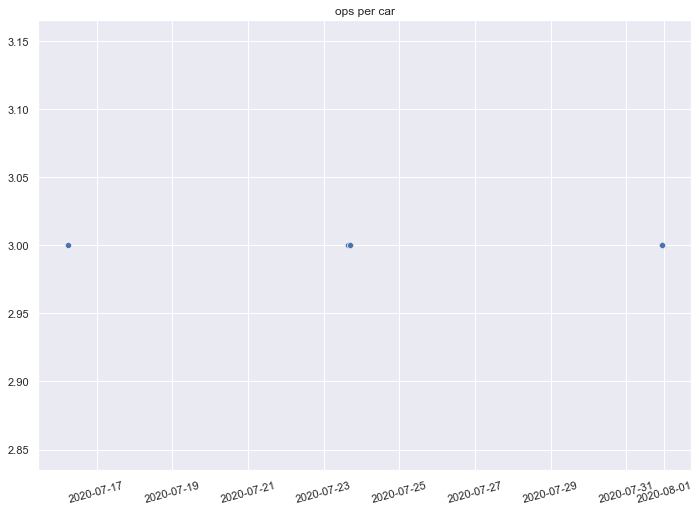

In [160]:
df1 =  df1.sort_values(by='operation_date').reset_index(drop=True)
    
sns.scatterplot(x=df1.operation_date.values,y=df1.operation_car.values)
plt.xticks(rotation=15)
plt.title('ops per car')
# plt.ylim(0, 10)
plt.minorticks_on()
# plt.grid(which='both')
plt.show()

In [16]:
ndf[ndf.car_number == 62324355]

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,operation_st_esr,operation_st_id,operation_train,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto
3211667,NaN,1.00,62324355,"864,207.00",20.00,NaN,"141,092.00",NaN,10.00,2020-07-15 23:50:00,"860,206.00","2,001,930,760.00",NaN,"5,757,676.00",60.00,NaN,"5,757,676.00",NaN,NaN,240.00,NaN
3211668,"860,206,179,864,207.00",1.00,62324355,"864,207.00",NaN,NaN,"141,092.00",1.00,4.00,2020-07-16 00:15:00,"860,206.00","2,001,930,760.00",5.00,"5,757,676.00",60.00,50.00,"5,757,676.00","860,206.00","2,001,930,760.00",NaN,"5,954.00"
3211669,"860,206,179,864,207.00",1.00,62324355,"864,207.00",NaN,NaN,"141,092.00",1.00,4.00,2020-07-16 00:18:00,"860,206.00","2,001,930,760.00",5.00,"5,757,676.00",60.00,50.00,"5,757,676.00","860,206.00","2,001,930,760.00",NaN,"5,954.00"
3211670,"860,206,179,864,207.00",1.00,62324355,"864,207.00",NaN,NaN,"141,092.00",NaN,2.00,2020-07-16 02:22:00,"860,206.00","2,001,930,760.00",2.00,"5,757,676.00",60.00,50.00,"5,757,676.00","864,207.00","2,001,930,816.00",NaN,"5,954.00"
3211671,"864,207,177,860,206.00",NaN,62324355,"860,206.00",NaN,NaN,NaN,2.00,3.00,2020-07-17 04:20:00,"860,206.00","2,001,930,760.00",4.00,NaN,60.00,40.00,NaN,"860,206.00","2,001,930,760.00",NaN,"1,537.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3537350,"864,207,205,860,206.00",1.00,62324355,"860,206.00",NaN,NaN,"141,092.00",2.00,4.00,2020-07-28 05:24:00,"864,207.00","2,001,930,816.00",5.00,"5,757,676.00",60.00,50.00,"93,315,475.00","864,207.00","2,001,930,816.00",NaN,"1,518.00"
3537351,"864,207,205,860,206.00",1.00,62324355,"860,206.00",NaN,NaN,"141,092.00",NaN,2.00,2020-07-28 07:29:00,"864,207.00","2,001,930,816.00",62.00,"5,757,676.00",60.00,50.00,"93,315,475.00","860,206.00","2,001,930,760.00",NaN,"1,518.00"
3537352,"860,206,252,864,207.00",NaN,62324355,"864,207.00",NaN,NaN,NaN,1.00,3.00,2020-07-29 20:51:00,"864,207.00","2,001,930,816.00",4.00,NaN,60.00,NaN,NaN,"864,207.00","2,001,930,816.00",NaN,NaN
3537353,NaN,NaN,62324355,"864,207.00",NaN,NaN,NaN,1.00,80.00,2020-07-29 22:45:00,"864,207.00","2,001,930,816.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

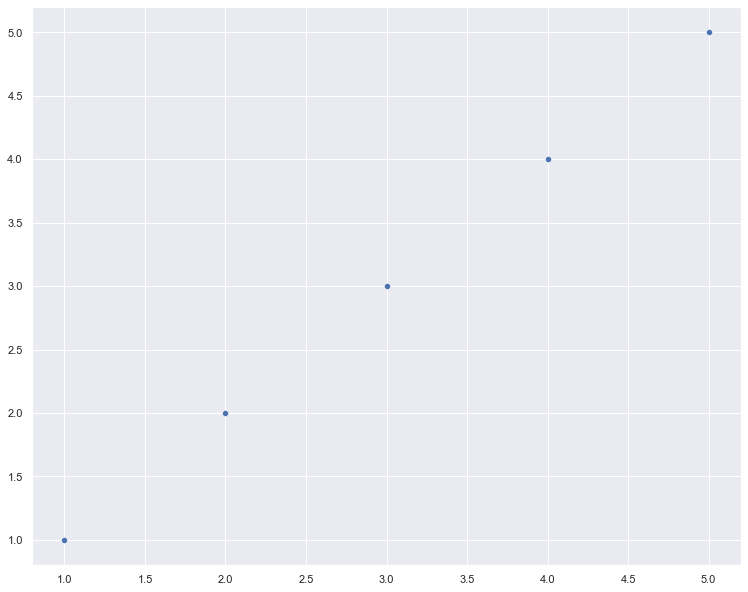

In [231]:
x = [1,2,3,4,5]
y = [1,2,3,4,5]
sns.scatterplot(x=x,y=y)

In [237]:
st_df[['car_number','operation_car']]

,car_number,operation_car
0,37845930,3.00
1,37845930,80.00
2,37845955,3.00
3,37845955,80.00
4,37845930,28.00
...,...,...
96,55853279,80.00
97,55808646,80.00
98,55816227,80.00
99,52007580,28.00


In [315]:
# уникальные станции по операциям
df.operation_st_id.value_counts()[df.operation_st_id.value_counts() > 500]

2,000,038,976.00    207099
2,000,038,600.00    146427
2,000,037,862.00    116936
2,001,933,494.00     96307
2,001,930,816.00     82794
                     ...  
2,000,037,074.00       545
2,001,933,426.00       541
2,000,038,498.00       520
2,000,038,910.00       516
2,002,023,867.00       515
Name: operation_st_id, Length: 433, dtype: int64

In [317]:
print(f'В датасете по станции {st_id}, имеются записи по:\n{ndf.car_number[ndf.operation_st_id == st_id].nunique()} вагонам и\n{ndf[ndf.operation_st_id == st_id].shape[0]} операциям')

В датасете по станции 2002023867, имеются записи по:
74 вагонам и
515 операциям


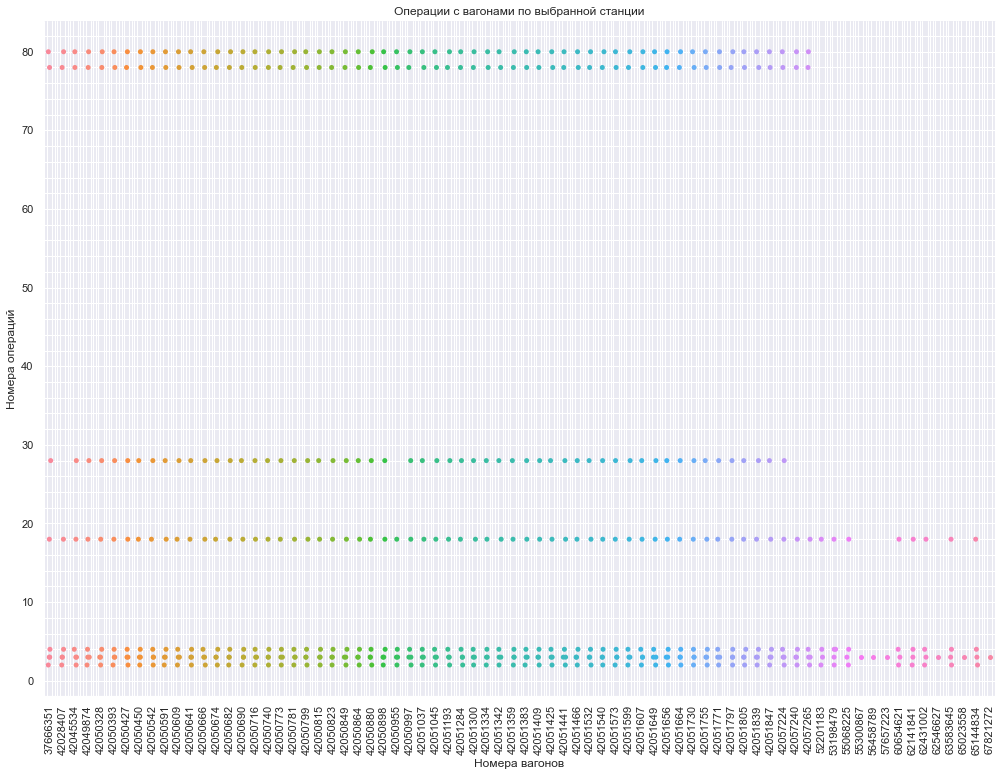

In [316]:
# st_id = 2000035744 # 100 ops, 4 cars
# st_id = 2002023503 # 90 ops, 28 cars
# st_id = 2000038836 # 50 ops, 10 cars
# st_id = 2000039118 # 54 ops, 9 cars
st_id = 2002023867 # 515 ops, 74 cars

st_df = ndf[ndf.operation_st_id == st_id].sort_values(by=['operation_date']).reset_index(drop=True)
st_df = st_df[['car_number','operation_car']]

sns.catplot(x=st_df['car_number'], y=st_df['operation_car'], data=st_df,height=10, aspect=11.7/8.27)
plt.ylabel('Номера операций')
plt.xlabel('Номера вагонов')
plt.xticks(rotation=90)
plt.minorticks_on()
plt.grid(which='both')
plt.grid(axis='both')
plt.title('Операции с вагонами по выбранной станции')
plt.show()

In [246]:
ndf[ndf.operation_st_id == 2000035744]['operation_car']

391569    3.00
391570   28.00
391571    4.00
391572    2.00
391573   28.00
          ... 
391664    2.00
391665    3.00
391666   18.00
391667    4.00
391668    2.00
Name: operation_car, Length: 100, dtype: float64